In [39]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd

import librosa
import csv
import scipy
import matplotlib.pyplot as plt
import os

from IPython.display import Audio

In [4]:
DATASET = './DataSets/Emotions'

In [5]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

In [6]:
wav_path = f'{DATASET}/Angry/03-01-05-01-01-01-01.wav'
wav_data, sample_rate = librosa.load(wav_path)
print(f'Original sample rate: {sample_rate} Hz')

# Ensure that the sample rate is set to 16 kHz and calculate the sample length in seconds.
waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
duration = len(waveform)/sample_rate

# Show some basic information about the audio.
print(f'Model Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(waveform)}')

# Listening to the wav file.
Audio(waveform, rate=sample_rate)

Original sample rate: 22050 Hz
Model Sample rate: 16000 Hz
Total duration: 3.87s
Size of the input: 61929


In [31]:
labels = {
    'Angry': 0,
    'Happy': 1,
    'Sad': 2,
    'Fearful': 3,
    'Disgusted': 4,
    'Neutral': 5,
    'Suprised': 6
}

In [33]:
paths = []

for dirname, _, filenames in os.walk(DATASET):
    print(dirname, len(filenames))
    for filename in filenames:
        path = os.path.join(dirname, filename)
        category = dirname.split('\\')[-1]
        paths.append((path, category, labels[category]))

./DataSets/Emotions 0
./DataSets/Emotions\Angry 2167
./DataSets/Emotions\Disgusted 1863
./DataSets/Emotions\Fearful 2047
./DataSets/Emotions\Happy 2167
./DataSets/Emotions\Neutral 1795
./DataSets/Emotions\Sad 2167
./DataSets/Emotions\Suprised 592


In [34]:
emotions = pd.DataFrame(paths, columns=['path', 'emotion', 'label'])

In [35]:
emotions.head()

,path,emotion,label
0,./DataSets/Emotions\Angry\03-01-05-01-01-01-01...,Angry,0
1,./DataSets/Emotions\Angry\03-01-05-01-01-01-02...,Angry,0
2,./DataSets/Emotions\Angry\03-01-05-01-01-01-03...,Angry,0
3,./DataSets/Emotions\Angry\03-01-05-01-01-01-04...,Angry,0
4,./DataSets/Emotions\Angry\03-01-05-01-01-01-05...,Angry,0


In [30]:
emotions.emotion.value_counts()

Angry        2167
Happy        2167
Sad          2167
Fearful      2047
Disgusted    1863
Neutral      1795
Suprised      592
Name: emotion, dtype: int64

### Audio processing with yamnet

In [42]:
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [43]:
def class_names_from_csv(class_map):
    csv_file = tf.io.gfile.GFile(class_map)
    reader = csv.DictReader(csv_file)
    class_names = [row['display_name'] for row in reader]
    return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [44]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

# Print the highest-scoring classes and their scores.
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
top_class = scores_np.mean(axis=0).argmax()
infered_class = class_names[top_class]

# results
print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Speech
The embeddings shape: (8, 1024)


In [142]:
spectrogram_np.shape

(432, 64)

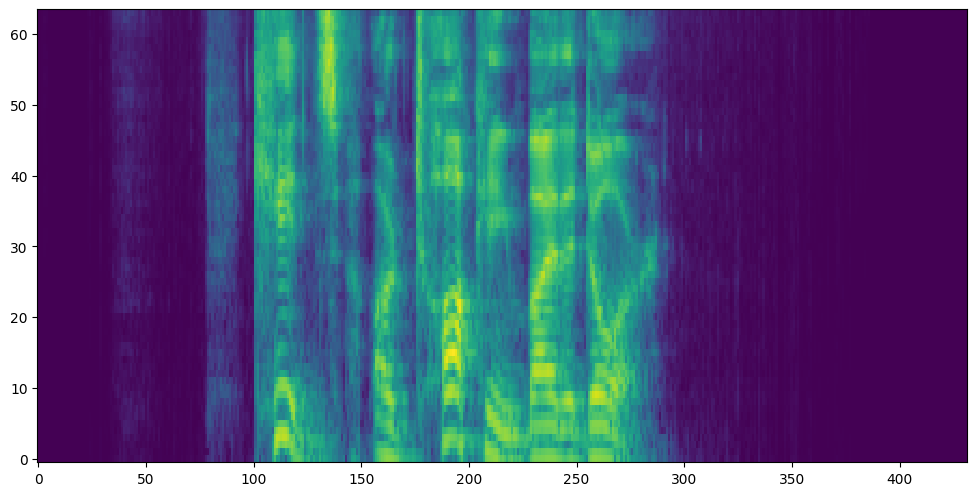

In [143]:
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

### Processing the data

Audio processing
https://klyshko.github.io/teaching/2019-02-22-teaching


In [71]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 7)

In [57]:
max(waveform), min(waveform), max(waveform)-min(waveform), sum(waveform), len(waveform), sum(waveform)/len(waveform)

(0.18135378,
 -0.147245,
 0.3285988,
 0.9779049819188937,
 61929,
 1.5790743947405798e-05)

In [60]:
# total time
len(waveform)/sample_rate, sample_rate

(3.8705625, 16000)

In [65]:
1./waveform

array([-243004.52,  243120.72, -243015.08, ...,  243387.17, -243192.08,
        243242.3 ], dtype=float32)

In [97]:
sampFreq, sound = wavfile.read(f'{DATASET}/Angry/03-01-05-01-01-01-01.wav')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17204\3913419011.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(f'{DATASET}/Angry/03-01-05-01-01-01-01.wav')


In [98]:
sound = sound / 2.0**15
sound.shape

(185786,)

In [99]:
length_in_s = sound.shape[0] / sampFreq
print(length_in_s)

3.8705416666666665


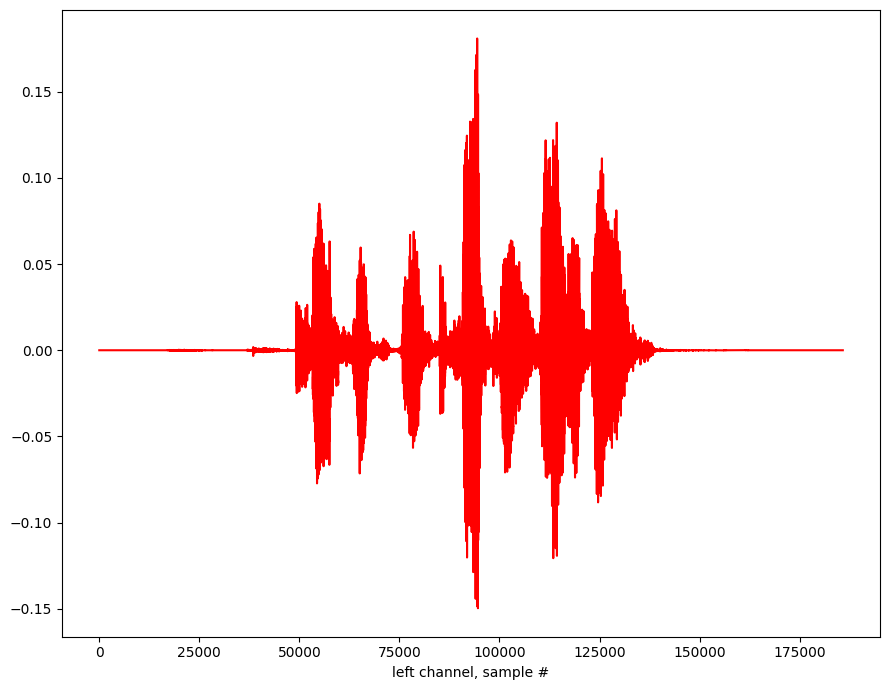

In [100]:
plt.plot(sound, 'r')
plt.xlabel("left channel, sample #")
plt.tight_layout()
plt.show()

In [101]:
length_in_s = sound.shape[0] / sampFreq
time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s

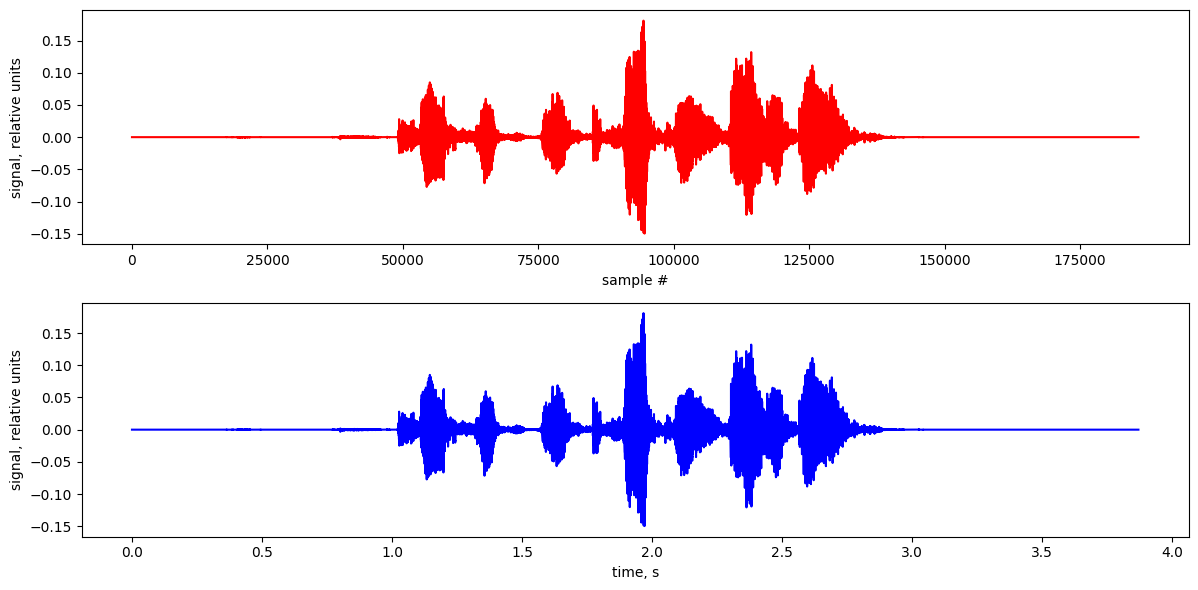

In [144]:
plt.subplot(2,1,1)
plt.plot(sound, 'r')
plt.xlabel("sample #")
plt.ylabel("signal, relative units")
plt.subplot(2,1,2)
plt.plot(time, sound, 'b')
plt.xlabel("time, s")
plt.ylabel("signal, relative units")
plt.tight_layout()
plt.show()

In [103]:
signal = sound

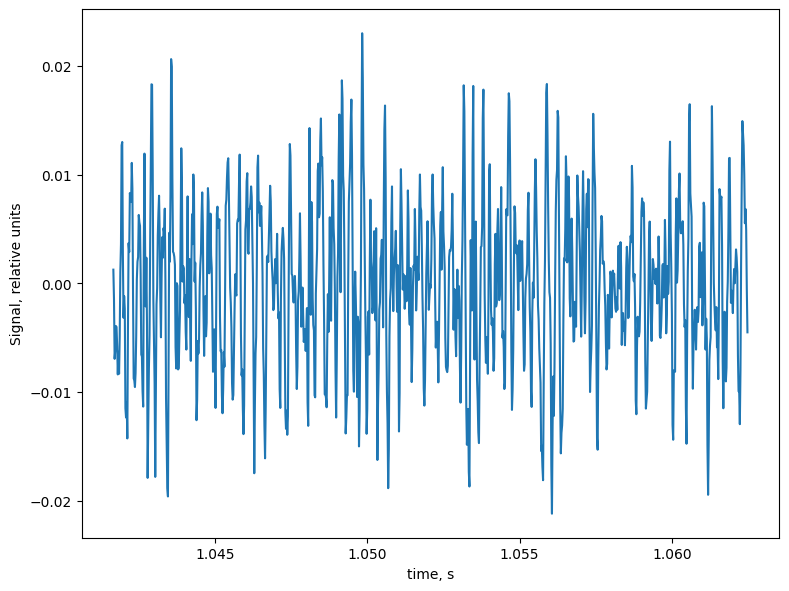

In [104]:
start = 50000
spam = start+1000
plt.plot(time[start:spam], signal[start:spam])
plt.xlabel("time, s")
plt.ylabel("Signal, relative units")
plt.show()

In [105]:
fft_spectrum = np.fft.rfft(signal)
freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
fft_spectrum_abs = np.abs(fft_spectrum)

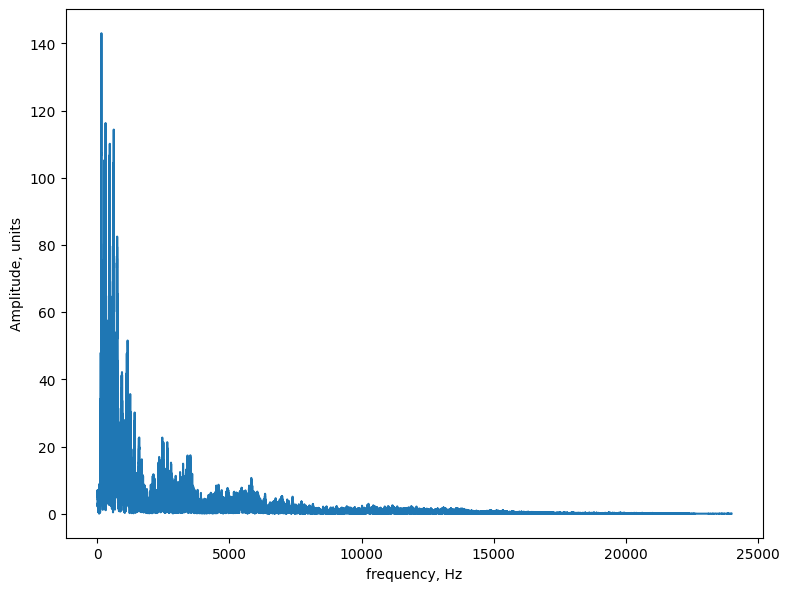

In [106]:
plt.plot(freq, fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

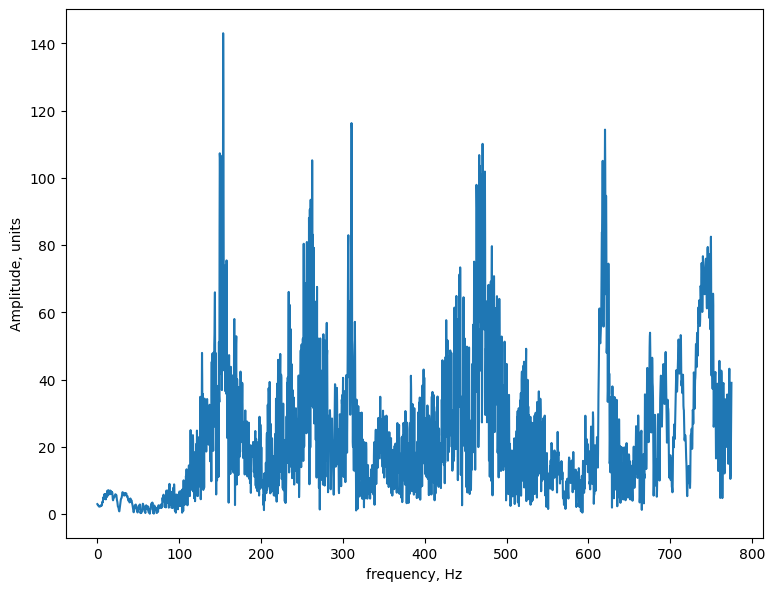

In [110]:
plt.plot(freq[:3000], fft_spectrum_abs[:3000])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

In [112]:
for i,f in enumerate(fft_spectrum_abs):
    if f > 60: #looking at amplitudes of the spikes higher than 60 
        print('frequency = {} Hz with amplitude {} '.format(np.round(freq[i],1),  np.round(f)))

frequency = 143.4 Hz with amplitude 61.0 
frequency = 143.6 Hz with amplitude 66.0 
frequency = 149.3 Hz with amplitude 85.0 
frequency = 149.6 Hz with amplitude 107.0 
frequency = 149.8 Hz with amplitude 106.0 
frequency = 150.1 Hz with amplitude 90.0 
frequency = 150.6 Hz with amplitude 71.0 
frequency = 150.9 Hz with amplitude 89.0 
frequency = 151.7 Hz with amplitude 61.0 
frequency = 152.4 Hz with amplitude 60.0 
frequency = 152.7 Hz with amplitude 105.0 
frequency = 153.0 Hz with amplitude 107.0 
frequency = 153.5 Hz with amplitude 91.0 
frequency = 153.7 Hz with amplitude 143.0 
frequency = 154.0 Hz with amplitude 125.0 
frequency = 154.2 Hz with amplitude 85.0 
frequency = 154.5 Hz with amplitude 61.0 
frequency = 155.5 Hz with amplitude 71.0 
frequency = 155.8 Hz with amplitude 70.0 
frequency = 156.6 Hz with amplitude 63.0 
frequency = 156.8 Hz with amplitude 74.0 
frequency = 157.1 Hz with amplitude 66.0 
frequency = 157.9 Hz with amplitude 75.0 
frequency = 158.1 Hz with am

# prepare the data
https://www.kaggle.com/code/thanatoz/understanding-metric-and-visualizing-audio/notebook

In [115]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
import plotly.figure_factory as ff

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [116]:
import librosa
from librosa import display

In [117]:
audio_path = f'{DATASET}/Angry/03-01-05-01-01-01-01.wav'
x, sr = librosa.load(audio_path)

In [118]:
print(x.shape, sr)

(85346,) 22050


In [119]:
librosa.load(audio_path, sr=44100)

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 44100)

In [120]:
import IPython.display as ipyd
ipyd.Audio(audio_path)

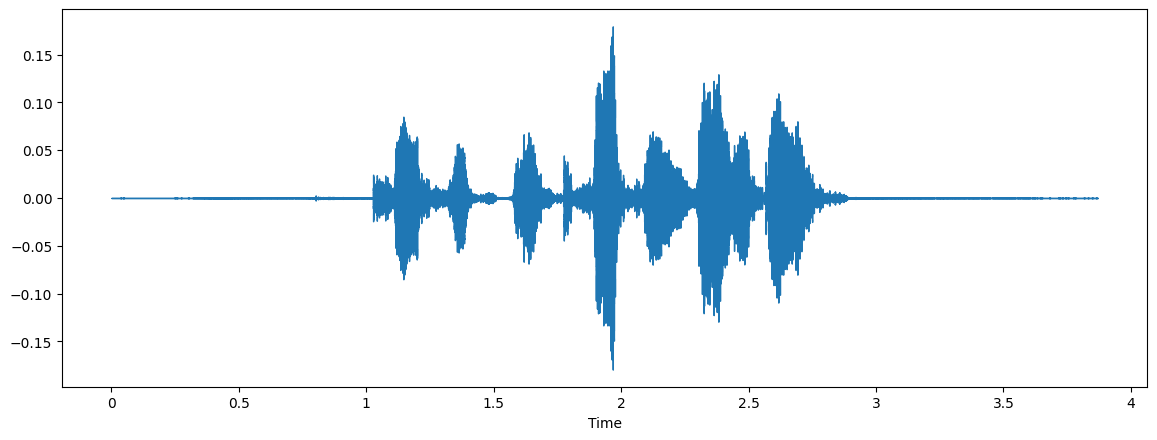

In [122]:
plt.figure(figsize=(14, 5))
display.waveshow(x, sr=sr)

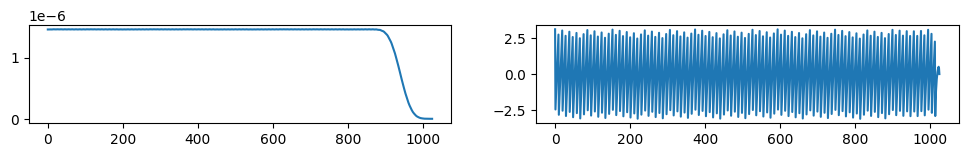

In [208]:
# Short-time Fourier transform (STFT)
n_fft = 2048
# D = np.abs(librosa.stft(x[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
D = np.abs(librosa.stft(x[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.subplot(4, 2, 1)
# D = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D)
plt.subplot(4, 2, 2)
D = np.angle(librosa.stft(x[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D)

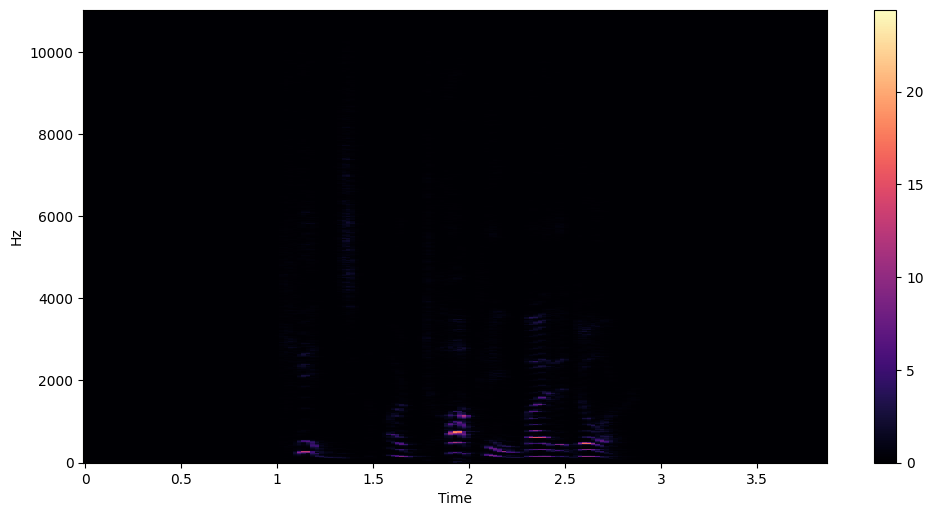

In [210]:
# Short-time Fourier transform (STFT)
hop_length = 512
D = np.abs(librosa.stft(x, n_fft=n_fft,  hop_length=hop_length))
display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

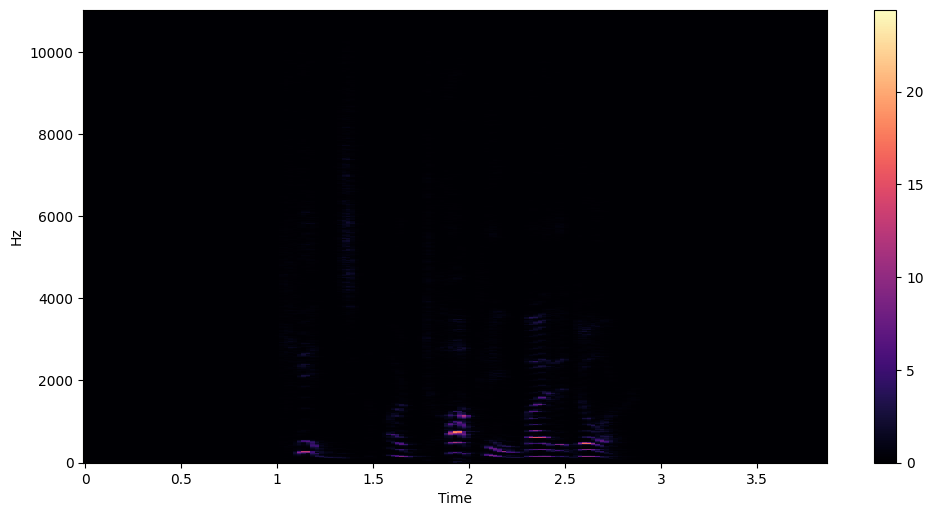

In [167]:
# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(x, n_fft=n_fft))
display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

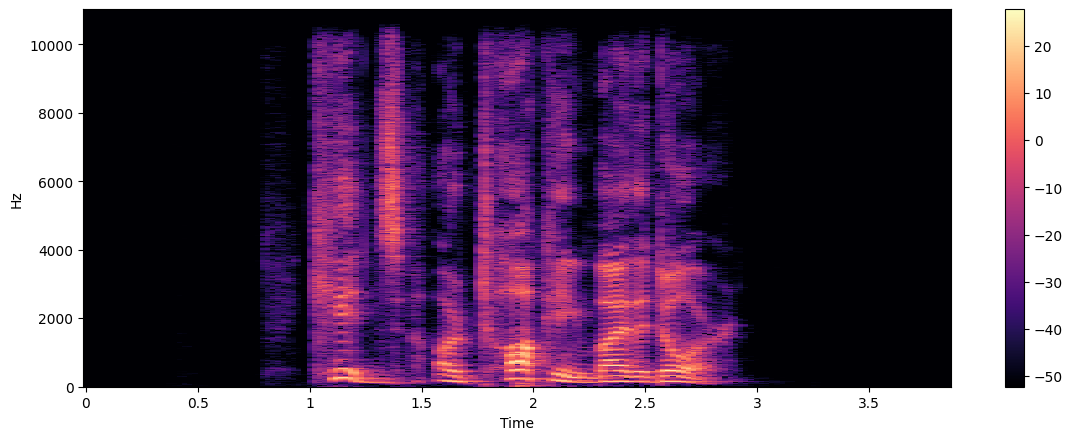

In [125]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

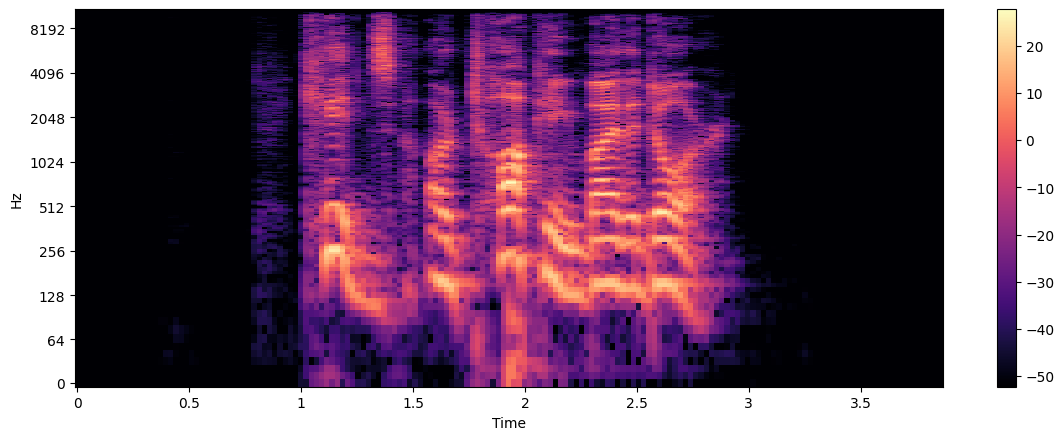

In [126]:
plt.figure(figsize=(14, 5))
display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

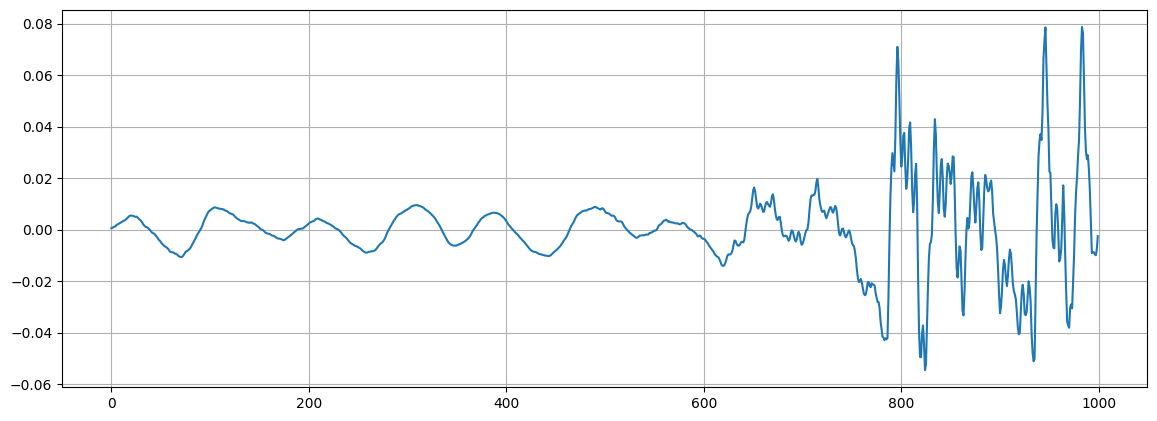

In [129]:
# Zooming in the amplitute envelope
n0 = 50000
n1 = 51000
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [172]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

35


In [169]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17204\248071343.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]


(167,)

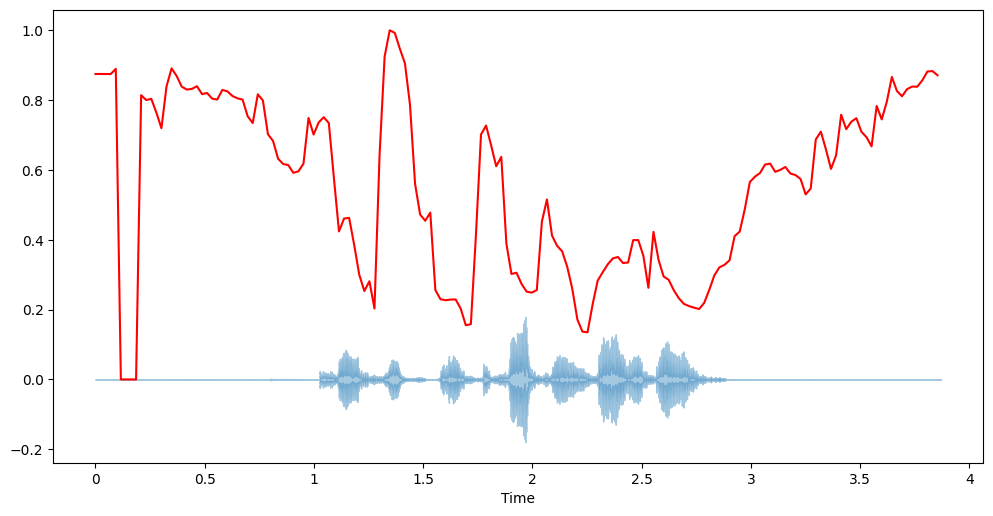

In [133]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

(167,) (167,)


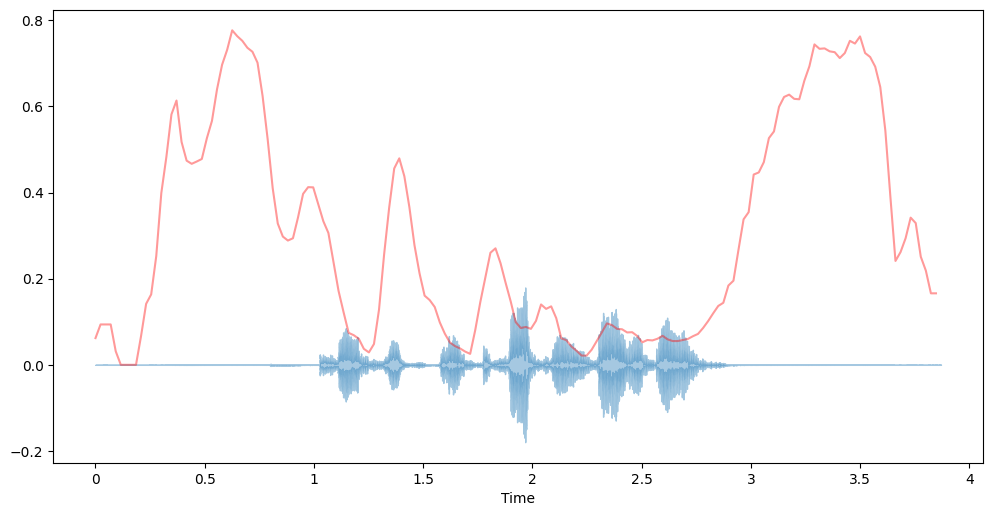

In [203]:
librosa.display.waveshow(x, sr=sr, alpha=0.4)
zcr = librosa.feature.zero_crossing_rate(x)[0]
length_in_s = x.shape[0] / sr
time = np.arange(zcr.shape[0]) / zcr.shape[0] * length_in_s
print(time.shape, zcr.shape)
plt.plot(time, zcr, color='r', alpha=0.4)

In [134]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

(20, 167)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17204\205689933.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


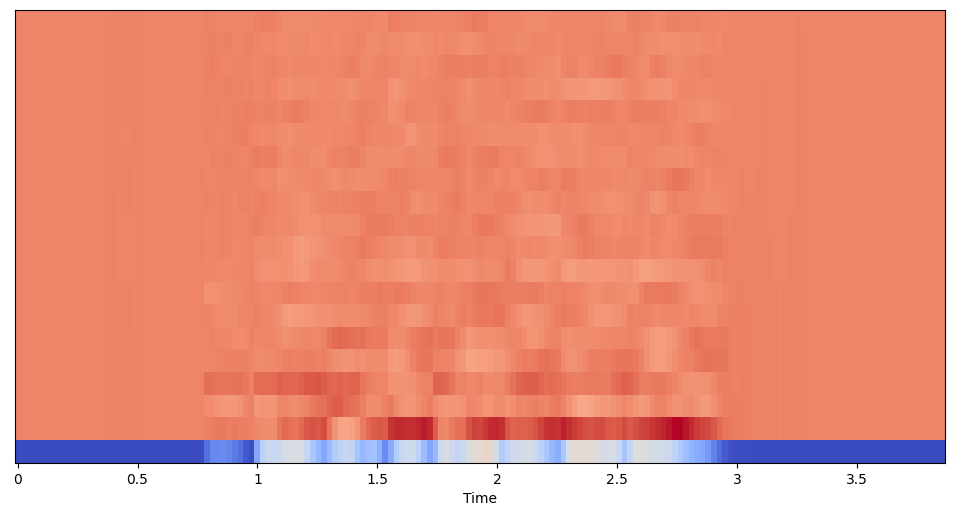

In [135]:
#Displaying  the MFCCs:
display.specshow(mfccs, sr=sr, x_axis='time')

In [151]:
# remove silence at the beginning and at the end of the signal
def remove_silence(signal, threshold=0.01):
    signal = signal.copy()
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    signal = signal[i:]
    for i in range(len(signal)-1, 0, -1):
        if np.abs(signal[i]) > threshold:
            break
    signal = signal[:i]
    return signal

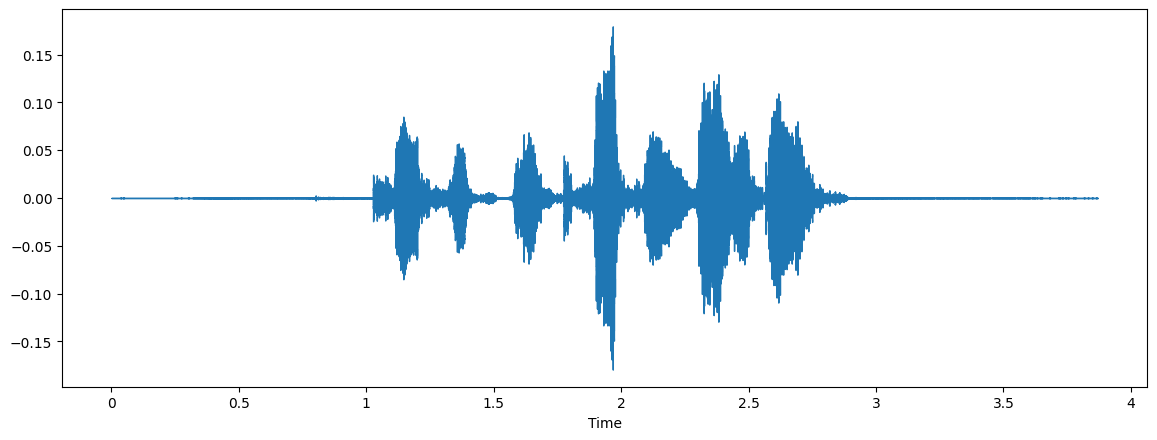

In [153]:
plt.figure(figsize=(14, 5))
display.waveshow(x, sr=sr)

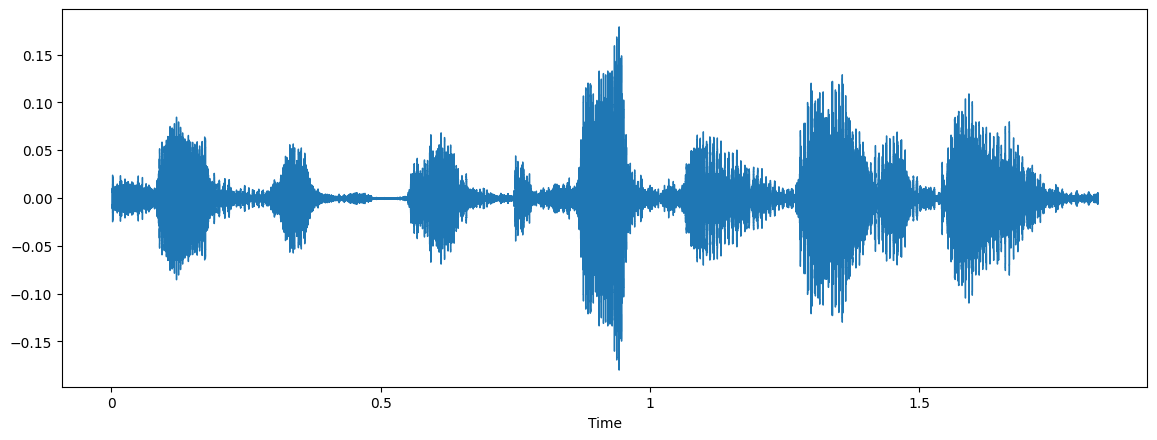

In [157]:
xx = remove_silence(signal=x, threshold=0.005)
plt.figure(figsize=(14, 5))
display.waveshow(xx, sr=sr)

In [158]:
spectral_centroids = librosa.feature.spectral_centroid(xx, sr=sr)[0]
spectral_centroids.shape

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17204\2838959797.py:1: FutureWarning: Pass y=[ 0.00574573  0.0022357  -0.00508252 ... -0.00125577 -0.00317152
 -0.00437967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(xx, sr=sr)[0]


(79,)

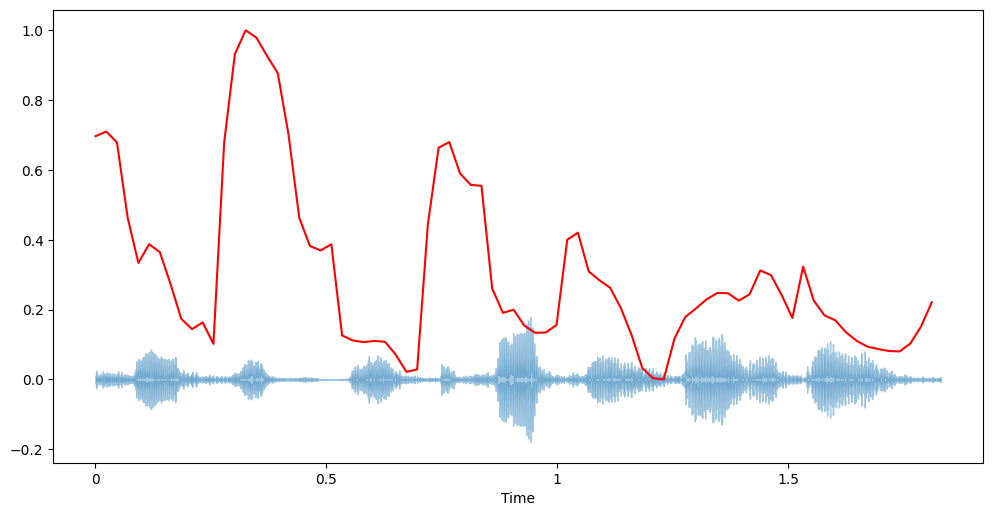

In [161]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(xx, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
# plt.plot(t, spectral_centroids, color='r')

In [164]:
ipyd.Audio(xx, rate=sr)